In [36]:
from sklearn.preprocessing import StandardScaler

from upbit_control import upbit_control
import tensorflow as tf
from tensorflow import keras

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.models import load_model

# pip install tensorflow==2.13

import pandas as pd
import numpy as np

In [39]:
class coin_class:
    def __init__(self, coin_full_name, ago):
        self.upbit = upbit_control()
        self.window = 200
        self.coin_name =  coin_full_name[:coin_full_name.index('_')]
        # 시작시 코인가져오기
        self.model = self.get_model(coin_full_name = coin_full_name)
        self.ago = ago
        
        ######### 코인이름 임시입니다.
    def pre_processing(self):
        # 롤링평균 과거 200개 값 필요합니다.
        
        # 지금시간의 코인데이터 반환 long길이만큼
        now_coin = self.upbit.request_upbit_long_data(self.ago, self.coin_name)
        ### 모델이 요구하는 형태로 변환
        now_coin.drop(columns=["market", "candle_date_time_utc","candle_date_time_kst","unit" ], inplace=True)
        now_coin["timestamp"] = now_coin["timestamp"].round(-3)
        # 롤링평균& 데이터 생성 
        rol_mean = now_coin["trade_price"].rolling(self.window).mean()
        rol_half_mean = now_coin["trade_price"].rolling(int(self.window/2)).mean()
        rol_std = now_coin["trade_price"].rolling(self.window).std()
        rol_half_std = now_coin["trade_price"].rolling(int(self.window/2)).std()
        temp_rol = pd.concat([rol_mean, rol_half_mean, rol_std, rol_half_std], axis=1)
        temp_rol.columns = ["rol_mean","rol_half_mean","rol_std","rol_half_std"]
        now_coin = pd.concat([now_coin, temp_rol], axis=1)
        
        # nan값 처리
        now_coin = now_coin[self.window:]
        now_coin.reset_index(drop=True, inplace=True)
        
        
        # 데이터 스케일링
        ss = StandardScaler()
        now_coin = ss.fit_transform(now_coin)
        ## LSTM이 요구하는 형태로 변환
        now_coin_np = np.zeros((len(now_coin) - self.window +1, self.window, now_coin.shape[1]), dtype=np.float32)
        for index in range(self.window, len(now_coin) +1):
            now_coin_np[index - self.window] = now_coin[index - self.window : index]
        return  now_coin_np
        # 모델 가져오기
    def get_model(self, coin_full_name):
        model_path = f'./model/LSTMEND{coin_full_name}.keras'
        model = tf.keras.models.load_model(model_path, compile=False)
        RMSprop = keras.optimizers.RMSprop(learning_rate=0.01)
        model.compile(optimizer= RMSprop, loss='mae', metrics=["mse"])
        return model
    
    def predict_coin(self, now_coin_np  ):
        y_pred = self.model.predict(now_coin_np)
        return y_pred

if __name__ == "__main__":
    coin_class = coin_class( coin_full_name= "KRW-ETH_이더리움", ago = 600)
    now_coin_np = coin_class.pre_processing()
    ypred = coin_class.predict_coin(now_coin_np)
    ypred




7/7 [==============================] - 0s 18ms/step


[[2119243.5]] [[2094637.]]

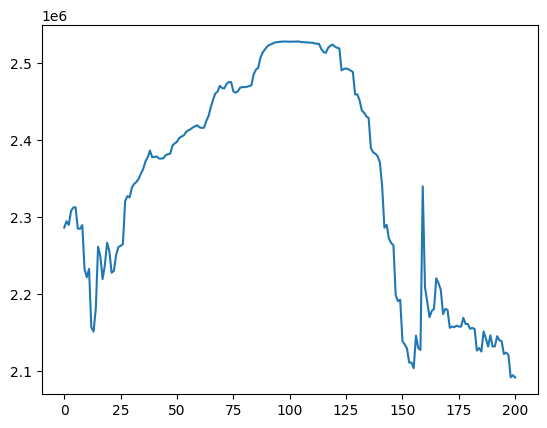

In [41]:
import matplotlib.pyplot as plt

plt.plot(ypred)
